# Compare ConsensusTME NACT NES through paired analysis

Script related to figure 6a

### Aim:
- Compare gene sets NES (matched and unmatched) using paired analysis

In [1]:
!python --version

Python 3.6.8 :: Anaconda custom (64-bit)


## Import packages

In [4]:
import sys
import scipy
import numpy as np
import pandas as pd
from scipy.stats import t
import matplotlib.pyplot as plt
from scipy.stats.mstats import normaltest
from statsmodels.sandbox.stats.multicomp import multipletests
from scipy.stats import shapiro, kstest, ttest_rel, wilcoxon, mannwhitneyu, ttest_ind, bartlett

In [5]:
home = '~/git_repos/HGSOC_TME_Heterogeneity/'

## Get sample labels

### Load file

In [6]:
file_keys = home + 'Data/5/NACT_SampleLabels.txt'

sample_labels = pd.read_csv(file_keys,
                            sep='\t',
                            index_col='Well')

sample_labels.head()

,Name,Case_mRNA,NACT,Site,Bounds
Well,,,,,
A01,A01_3368A_Liver,3368,Untreated,other,in
A02,A02_3368B_Liver,3368,Treated,other,out
A03,A03_0371A_R_diaphragm,371,Untreated,other,out
A04,A04_0371B_R_diaphragm,371,Treated,other,out
A05,A05_9717A_R_ovary,9717,Untreated,ovary,in


In [7]:
len(set(sample_labels.Case_mRNA))

28

In [8]:
matched = [3368,371,9717,8674,2359,564,7765,6965,9347]

sample_labels['Matched']=sample_labels['Case_mRNA'].isin(matched)

sample_labels.head()

,Name,Case_mRNA,NACT,Site,Bounds,Matched
Well,,,,,,
A01,A01_3368A_Liver,3368,Untreated,other,in,True
A02,A02_3368B_Liver,3368,Treated,other,out,True
A03,A03_0371A_R_diaphragm,371,Untreated,other,out,True
A04,A04_0371B_R_diaphragm,371,Treated,other,out,True
A05,A05_9717A_R_ovary,9717,Untreated,ovary,in,True


## Load consensusTME ssGSEA results

In [9]:
file_nes = home + 'Data/5/ConsensusTME_NACT_NES.txt'

data_nes = pd.read_csv(file_nes,
                       sep='\t')

data_nes.set_index('Term',
                   inplace=True)

data_nes.head()

,A01,A02,A03,A04,A05,A06,A07,A08,A09,A10,...,D12,E01,E02,E03,E04,E05,E06,E07,E08,E09
Term,,,,,,,,,,,,,,,,,,,,,
B_cells,0.254477,0.183183,0.328434,0.222920,0.158446,0.208608,0.153616,0.241499,0.227171,0.243108,...,0.282397,0.200239,0.268572,0.135625,0.237829,0.174235,0.346601,0.451349,0.345059,0.261922
Cytotoxic_cells,0.160124,0.086828,0.250783,0.469283,0.149997,0.280421,0.183015,0.136132,-0.013996,-0.005431,...,0.119812,0.128451,0.053743,-0.061381,0.264916,0.130406,0.056087,0.426493,0.242746,0.000835
Dendritic_cells,0.234120,0.242725,0.358290,0.249668,0.096655,0.219568,0.186520,0.244219,0.175394,0.125974,...,0.195455,0.213759,0.300447,0.175864,0.352042,0.078574,0.344772,0.479416,0.396381,0.237165
Endothelial,0.141871,-0.031062,0.359779,0.385954,-0.038934,0.295855,-0.023180,0.343295,0.143790,0.186743,...,0.214454,0.263538,0.230676,0.182908,0.467953,0.115959,0.192065,0.339805,0.233110,0.231086
Eosinophils,-0.104190,-0.001942,0.118276,0.292186,-0.136142,-0.127744,0.022336,0.303864,-0.069590,0.074915,...,-0.178187,-0.153298,0.104774,-0.223999,0.083588,-0.064987,0.086109,0.351228,0.080969,0.007399


### Check empty cells

In [10]:
set(data_nes.isnull().sum())

{0}

## Load mRNA tumour cellularity data

In [11]:
mRNA_tumcell_file = home + 'Data/5/NACT_log2exp_loess_norm_filtered_ESTIMATE.txt'

mRNA_tumcell = pd.read_csv(mRNA_tumcell_file,
                           skiprows=2,
                           sep='\t',
                           index_col='NAME')

del(mRNA_tumcell['Description'])

mRNA_tumcell.head()

,A01,A02,A03,A04,A05,A06,A07,A08,A09,A10,...,D12,E01,E02,E03,E04,E05,E06,E07,E08,E09
NAME,,,,,,,,,,,,,,,,,,,,,
StromalScore,150.243978,100.962227,967.051900,808.453034,-65.569315,489.893858,490.720381,1061.377025,235.450362,418.150347,...,263.744096,464.939728,802.734452,153.081049,1103.804616,579.702569,788.616732,1237.456125,887.344608,501.153545
ImmuneScore,176.145317,526.978700,1297.193578,1203.727348,131.468582,650.323221,407.055460,1082.029608,88.028614,282.209677,...,481.526245,516.592649,582.005013,29.396052,908.321033,258.334588,849.462145,1496.053219,969.848566,621.394231
ESTIMATEScore,326.389295,627.940928,2264.245478,2012.180381,65.899267,1140.217080,897.775841,2143.406633,323.478976,700.360025,...,745.270341,981.532377,1384.739465,182.477100,2012.125649,838.037157,1638.078877,2733.509343,1857.193174,1122.547776
TumorPurity,0.794327,0.766668,0.591924,0.621334,0.816969,0.716267,0.740642,0.606127,0.794586,0.759799,...,0.755497,0.732326,0.690764,0.806982,0.621341,0.746506,0.663403,0.535046,0.638998,0.718075


### Add mRNA tumour cellularity to NES dataframe

In [12]:
data_nes_t = data_nes.T

In [13]:
data_nes_t['TumourCellularity_mRNA'] = mRNA_tumcell.loc['TumorPurity']

In [14]:
data_nes = data_nes_t.T

In [15]:
data_nes.tail()

,A01,A02,A03,A04,A05,A06,A07,A08,A09,A10,...,D12,E01,E02,E03,E04,E05,E06,E07,E08,E09
Term,,,,,,,,,,,,,,,,,,,,,
T_cells_CD4,-0.151260,-0.172278,0.154900,0.069036,-0.212100,-0.143919,-0.146261,-0.001396,-0.258183,-0.120923,...,-0.199379,-0.213471,-0.171529,-0.244783,-0.033248,-0.194803,-0.077282,0.163015,-0.007922,-0.093441
T_cells_CD8,-0.124588,-0.099327,0.098996,0.082092,-0.169720,-0.144463,-0.167269,-0.004968,-0.159959,-0.155491,...,-0.087820,-0.106419,-0.118318,-0.247615,0.025758,-0.182130,-0.034114,0.168739,0.004279,-0.072557
T_cells_gamma_delta,-0.121056,-0.110020,0.020995,0.065898,-0.180424,-0.120656,-0.143999,-0.051105,-0.231617,-0.171884,...,-0.089236,-0.112779,-0.147467,-0.258662,-0.023540,-0.152077,-0.047563,0.172180,-0.019459,-0.113018
T_regulatory_cells,-0.171317,-0.176621,0.124944,0.077918,-0.287924,-0.195206,-0.345462,0.040120,-0.353342,-0.133729,...,-0.229964,-0.182788,-0.230199,-0.264175,-0.043436,-0.208631,-0.065168,0.105513,-0.091520,-0.187371
TumourCellularity_mRNA,0.794327,0.766668,0.591924,0.621334,0.816969,0.716267,0.740642,0.606127,0.794586,0.759799,...,0.755497,0.732326,0.690764,0.806982,0.621341,0.746506,0.663403,0.535046,0.638998,0.718075


### Visulase NES

#### Samples

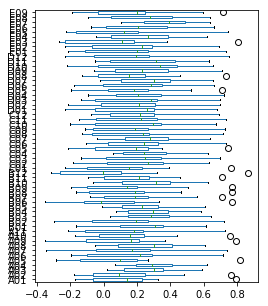

In [16]:
data_nes.plot(kind='box',
              vert=False,
              figsize=(4,5))

#### Variables

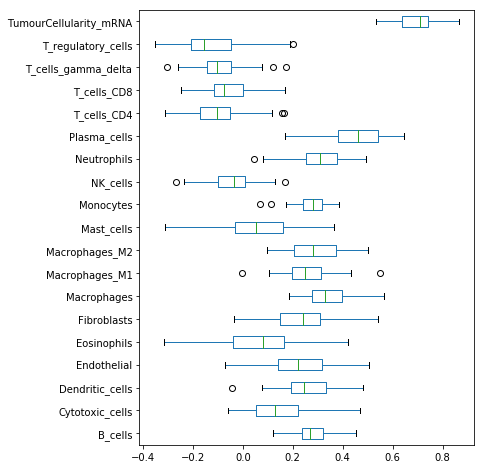

In [17]:
data_nes.transpose().plot(kind='box',
                          vert=False,
                          figsize=(6,8))

### Define stat functions for volcano plot

#### Test for equal variances

In [18]:
def test_variances(df, score, norm, not_norm):
    """
    test equal variances
    """
    
    if norm > not_norm:
        
        print("bartlett")
    
        p_var = bartlett(df[df.NACT=='Treated'][score],
                         df[df.NACT=='Untreated'][score])[1]
        
    else:
        
        print("levene")
        
        raise("ValueError")
        
        p_var = levene(df[df.NACT=='Treated'][score],
                         df[df.NACT=='Untreated'][score])[1]

    return p_var

#### Test normality

In [19]:
def test_paired_normality_and_variance(df, score):
    """
    test normality of distributions
    """
    normality = []
    normality.append(shapiro(df[df.NACT=='Treated'][score])[1])
    normality.append(shapiro(df[df.NACT=='Untreated'][score])[1])
    
    mean = np.mean(df[df.NACT=='Treated'][score])
    std = np.std(df[df.NACT=='Treated'][score])
    normality.append(kstest(list(df[df.NACT=='Treated'][score]),
                            'norm', args=(mean,std))[1])
    
    mean = np.mean(df[df.NACT=='Untreated'][score])
    std = np.std(df[df.NACT=='Untreated'][score])
    normality.append(kstest(list(df[df.NACT=='Untreated'][score]),
                            'norm', args=(mean,std))[1])
    
    normality.append(normaltest(list(df[df.NACT=='Treated'][score]))[1])
    normality.append(normaltest(list(df[df.NACT=='Untreated'][score]))[1])
    
    norm = 0
    not_norm = 0
    for p in normality:
        if p > 0.05:
            norm += 1
        else:
            not_norm += 1
            
    if norm > not_norm:
        p_var = test_variances(df, score, norm, not_norm)
        if p_var > 0.05:            
            return 't-test'
        else:
            return 'welch'
    else:        
        return 'wilcoxon'

In [20]:
def test_unpaired_normality_and_variance(df, score):
    """
    test normality of distributions
    """
    normality = []
    normality.append(shapiro(df[df.Matched==True][score])[1])
    normality.append(shapiro(df[df.Matched==False][score])[1])
    
    mean = np.mean(df[df.Matched==True][score])
    std = np.std(df[df.Matched==True][score])
    normality.append(kstest(list(df[df.Matched==True][score]),
                            'norm', args=(mean,std))[1])
    
    mean = np.mean(df[df.Matched==False][score])
    std = np.std(df[df.Matched==False][score])
    normality.append(kstest(list(df[df.Matched==False][score]),
                            'norm', args=(mean,std))[1])
    
    normality.append(normaltest(list(df[df.Matched==True][score]))[1])
    normality.append(normaltest(list(df[df.Matched==False][score]))[1])
    
    norm = 0
    not_norm = 0
    for p in normality:
        if p > 0.05:
            norm += 1
        else:
            not_norm += 1
            
    if norm > not_norm:
        p_var = test_variances(df, score, norm, not_norm)
        if p_var > 0.05:            
            return 't-test'
        else:
            return 'welch'
    else:        
        return 'mannwhitneyu'

#### Test paired difference

In [21]:
def test_paired_difference(df, score, norm):
    """
    test difference with paired t test or wilcoxon
    """
    if norm == 't-test':
        p_val = (ttest_rel(df[df.NACT=='Treated'][score],
                 df[df.NACT=='Untreated'][score])[1])
    elif norm == 'welch':
        p_val = (ttest_ind(df[df.NACT=='Treated'][score],
                 df[df.NACT=='Untreated'][score], equal_var=False)[1])
    elif norm == 'wilcoxon':
        p_val = (wilcoxon(df[df.NACT=='Treated'][score],
                 df[df.NACT=='Untreated'][score])[1])
    else:
        raise ValueError()
        
    return p_val

#### Test unpaired difference

In [22]:
def test_unpaired_difference(df, score, norm):
    """
    test difference with unpaired t test or wilcoxon
    """
    if norm == 't-test':
        print("t-test")
        p_val = (ttest_ind(df[df.Matched==True][score],
                 df[df.Matched==False][score])[1])
    elif norm == 'welch':
        print("welch")
        p_val = (ttest_ind(df[df.Matched==True][score],
                 df[df.Matched==False][score], equal_var=False)[1])
    elif norm == 'mannwhitneyu':
        print("mannwhitneyu")
        p_val = (mannwhitneyu(df[df.Matched==True][score],
                 df[df.Matched==False][score],alternative="two-sided")[1])
    else:
        raise ValueError()
        
    return p_val

#### Get NES difference

In [23]:
def nes_paired_difference(df, score):
    """
    get NES difference between groups
    """    
    
    df['norm01'] = (df[score] - df[score].min())/(df[score].max()-df[score].min())
    
    nes_treated = df[df.NACT=='Treated']['norm01'].median()
    nes_untreated = df[df.NACT=='Untreated']['norm01'].median()
 
    nes_norm_dif = np.log2(nes_treated/nes_untreated)

    return nes_norm_dif, nes_treated, nes_untreated

In [24]:
def nes_unpaired_difference(df, score):
    """
    get NES difference between groups
    """    
    
    df['norm01'] = (df[score] - df[score].min())/(df[score].max()-df[score].min())
    
    nes_matched = df[df.Matched==True]['norm01'].median()
    nes_unmatched = df[df.Matched==False]['norm01'].median()
 
    nes_norm_dif = np.log2(nes_matched/nes_unmatched)

    return nes_norm_dif, nes_matched, nes_unmatched

### Get fdr nes q values

In [25]:
def nes_q_values(df, score):
    """
    get treated and untreated median q-values from ssGSEA
    """
    
    nes_treated_qvalue = df[df.NACT=='Treated'][score].median()
    nes_untreated_qvalue = df[df.NACT=='Untreated'][score].median()
    
    return nes_treated_qvalue, nes_untreated_qvalue

### Gene set matched size (i.e. the overlapping genes btw my array and the set)

In [27]:
loess_exp = pd.read_csv(home + 'Data/5/NACT_log2exp_loess_norm.txt',
                        sep='\t',
                        index_col='Hugo_Symbol')

loess_exp.head()

,A01,A02,A03,A04,A05,A06,A07,A08,A09,A10,...,D12,E01,E02,E03,E04,E05,E06,E07,E08,E09
Hugo_Symbol,,,,,,,,,,,,,,,,,,,,,
A1BG,3.878105,3.954775,3.854334,3.974302,3.760565,3.757145,3.734362,3.935987,3.807211,3.514725,...,3.919331,3.896646,4.027690,3.685888,3.765937,4.086110,4.000239,3.662362,3.896871,3.654871
A2BP1,2.862997,3.279474,3.957806,3.993876,3.641308,3.249292,3.347323,3.358668,3.616479,3.572950,...,3.490291,4.059473,3.679676,3.418869,2.924245,3.346328,3.899451,3.933936,4.425151,3.723115
A2M,5.516461,5.882656,6.421447,5.980470,5.049547,5.220719,5.492205,6.471173,5.341425,5.482726,...,6.366298,6.483692,5.784733,4.950854,6.164623,4.974455,6.709993,6.645714,6.391323,6.134008
A2ML1,3.958668,4.100177,3.250522,3.396357,3.851866,4.052745,3.635604,3.143886,3.999510,3.988277,...,3.300078,3.488284,3.120832,3.868837,3.519030,3.891299,3.151470,3.353788,3.617326,3.950268
A4GALT,3.087003,2.995708,3.395173,2.859539,2.976988,3.332730,3.317251,3.490682,3.087911,3.153865,...,3.440970,3.364598,3.214461,2.922184,3.054724,2.811116,2.929423,3.364648,3.325120,3.196659


### Get consensus gene sets

In [28]:
consensus_genesets = pd.read_csv(
    home + 'Data/3/ConsensusTME_GeneSets.txt',
    sep = '\t'
).T

consensus_genesets.head()

,0,1,2,3,4,5,6,7,8,9,...,46,47,48,49,50,51,52,53,54,55
B_cells,BLNK,CD1C,CD37,CD53,CD69,CD80,FAIM3,GMIP,GPR18,HLA-DQA1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cytotoxic_cells,CTSW,GZMA,GZMB,GZMH,KLRB1,KLRK1,NKG7,PRF1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dendritic_cells,BCL2A1,BIRC3,CCL19,CCL4,CCR2,CCR5,CCR7,CD1C,CD80,CD86,...,TNFAIP6,TRAF1,TREM2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Endothelial,CD93,CDH5,EMCN,ERG,KDR,PCDH12,RAMP3,TFEC,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Eosinophils,ABHD2,BCL2A1,CCL4,CCR1,CD69,CSF2RB,GMIP,GPR65,LRMP,NCF2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
def get_matched_size(genesets, exp_matrix):
    size = {}
    for geneset in genesets.index:

        if geneset not in size:
            size[geneset] = {}
        else:
            raise ValueError('1')

        size[geneset] = len(set(genesets.loc[geneset])&set(exp_matrix.index))
    
    return size

In [30]:
consensus_msize = get_matched_size(consensus_genesets, loess_exp)

### Get hallmarks gene sets

In [31]:
hallmark_genesets = pd.read_csv(
    home + 'Data/1/HallmarksStromaImmune_GeneSets.txt',
    sep = '\t',
    header = None,
    index_col = 0
)

hallmark_genesets.drop(
    1,
    axis = "columns",
    inplace=True
)

hallmark_genesets.tail()

,2,3,4,5,6,7,8,9,10,11,...,192,193,194,195,196,197,198,199,200,201
0,,,,,,,,,,,,,,,,,,,,,
HALLMARK_KRAS_SIGNALING_UP,ANGPTL4,ITGA2,SPRY2,HBEGF,RBP4,HSD11B1,ETV4,GLRX,DUSP6,SCG5,...,WDR33,MYCN,FCER1G,PECAM1,FAM190B,SNAP91,EVI5,TNFRSF1B,GPNMB,TPH1
HALLMARK_KRAS_SIGNALING_DN,CDH16,SPTBN2,FGFR3,NOS1,PDE6B,SIDT1,NTF3,SCN10A,TAS2R4,DTNB,...,ZFP112,TFAP2B,CCDC132,CD80,ATP4A,ARPP21,SERPINB2,TLX1,EFHD1,P2RY4
HALLMARK_PANCREAS_BETA_CELLS,PAX6,NEUROD1,ISL1,NKX2-2,PCSK1,NKX6-1,SLC2A2,SEC11A,DCX,SPCS1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
StromalSignature,DCN,PAPPA,SFRP4,THBS2,LY86,CXCL14,FOXF1,COL10A1,ACTG2,APBB1IP,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ImmuneSignature,LCP2,LSP1,FYB,PLEK,HCK,IL10RA,LILRB1,NCKAP1L,LAIR1,NCF2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
hallmark_msize = get_matched_size(hallmark_genesets, loess_exp)

#### Select gene sets

In [33]:
h_size_dt = hallmark_msize
c_size_dt = consensus_msize

In [34]:
c_size_dt['TumourCellularity_mRNA'] = h_size_dt['StromalSignature'] + h_size_dt['ImmuneSignature']

### Define gene set colors

In [35]:
GREEN = '#007F00'
RED = '#CC0000'
GREY = '#D3D3D3'
BLUE = '#0000E5'
YELLOW = '#FFFF00'

color_sets = {
'Endothelial':                                  RED,
'B_cells':                                      '#A6CDE1',
'T_cells_CD8':                                  '#FFDD15',
'Cytotoxic_cells':                              '#FFD400',
'Dendritic_cells':                              '#A181BA',
'Eosinophils':                                  '#D8AF62',
'Macrophages':                                  '#F58A21',
'Macrophages_M1':                               '#F58A21',
'Macrophages_M2':                               '#F58A21',
'Monocytes':                                    '#F58A21',
'Mast_cells':                                   '#F7F29B',
'NK_cells':                                     '#70B09D',
'Neutrophils':                                  '#B05A28',
'T_cells_gamma_delta':                          '#4F9F45',
'T_cells_CD4':                                  '#EC1C24',
'T_regulatory_cells':                           '#67B853',
'Plasma_cells':                                 '#A6CDE1',
'Fibroblasts':                                  BLUE,
'TumourCellularity_mRNA':                       'k'
}

### Make dict with score -> q-value_diff, es-difference, es, q-value_Enrichment

In [36]:
msize_dt = c_size_dt

In [37]:
scores = []
p_comparisons = []
nes_dif = []
nes_treated_list = []
nes_untreated_list = []
nes_norm_treated_list = []
nes_norm_untreated_list = []
q_value_treated = []
q_value_untreated = []
colors = []
msizes = []
for score in data_nes.T:

    df_nes = pd.concat([sample_labels['Matched'],
                        sample_labels['NACT'],
                        data_nes.T[score]],
                        axis=1)

    df_nes = df_nes[df_nes['Matched'] == True]

    norm = test_paired_normality_and_variance(df_nes, score)

    scores.append(score)
    p_comparisons.append(test_paired_difference(df_nes, score, norm))
    nes_treated_list.append(df_nes[df_nes.NACT=='Treated'][score].median())
    nes_untreated_list.append(df_nes[df_nes.NACT=='Untreated'][score].median())
    nes_dif.append(nes_paired_difference(df_nes, score)[0])
    nes_norm_treated_list.append(nes_paired_difference(df_nes, score)[1])
    nes_norm_untreated_list.append(nes_paired_difference(df_nes, score)[2])
    colors.append(color_sets.get(score,'k'))
    
    if score in msize_dt:
        msizes.append(msize_dt[score])
    else:
        raise ValueError()

qs = multipletests(pvals=p_comparisons,
                   alpha=0.05,
                   method='fdr_bh',
                   is_sorted=False)

/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))


bartlett
bartlett


/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/s

bartlett
bartlett
bartlett
bartlett


/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))


bartlett
bartlett


/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))


bartlett
bartlett


/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))


bartlett
bartlett


/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))


bartlett
bartlett


/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))


bartlett
bartlett


/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))


bartlett
bartlett
bartlett


/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))


In [38]:
ps_real = p_comparisons
qs_real = qs[1]
log10_ps_plot = abs(np.log10(p_comparisons))
log10_qs_plot = abs(np.log10(qs[1]))

### Volcano Plot

In [39]:
volcano_data = pd.DataFrame({'scores': pd.Series(scores),
                             'qs':pd.Series(qs_real),
                             'ps':pd.Series(ps_real),
                             'log10_q_comparison': pd.Series(log10_qs_plot),
                             'log10_p_comparison': pd.Series(log10_ps_plot),
                             'nes_dif': pd.Series(nes_dif),
                             'nes_treated': pd.Series(nes_treated_list),
                             'nes_untreated': pd.Series(nes_untreated_list),
                             'nes_norm_treated': pd.Series(nes_norm_treated_list),
                             'nes_norm_untreated': pd.Series(nes_norm_untreated_list),
                             'colors': pd.Series(colors),
                             'msizes':pd.Series(msizes)})

In [40]:
volcano_data[volcano_data.scores == 'TumourCellularity_mRNA']

,scores,qs,ps,log10_q_comparison,log10_p_comparison,nes_dif,nes_treated,nes_untreated,nes_norm_treated,nes_norm_untreated,colors,msizes
18,TumourCellularity_mRNA,0.068337,0.017984,1.165342,1.745125,-2.192512,0.621334,0.740642,0.145867,0.666761,k,278


### Hyperbolic curves

In [41]:
data_nes.head()

,A01,A02,A03,A04,A05,A06,A07,A08,A09,A10,...,D12,E01,E02,E03,E04,E05,E06,E07,E08,E09
Term,,,,,,,,,,,,,,,,,,,,,
B_cells,0.254477,0.183183,0.328434,0.222920,0.158446,0.208608,0.153616,0.241499,0.227171,0.243108,...,0.282397,0.200239,0.268572,0.135625,0.237829,0.174235,0.346601,0.451349,0.345059,0.261922
Cytotoxic_cells,0.160124,0.086828,0.250783,0.469283,0.149997,0.280421,0.183015,0.136132,-0.013996,-0.005431,...,0.119812,0.128451,0.053743,-0.061381,0.264916,0.130406,0.056087,0.426493,0.242746,0.000835
Dendritic_cells,0.234120,0.242725,0.358290,0.249668,0.096655,0.219568,0.186520,0.244219,0.175394,0.125974,...,0.195455,0.213759,0.300447,0.175864,0.352042,0.078574,0.344772,0.479416,0.396381,0.237165
Endothelial,0.141871,-0.031062,0.359779,0.385954,-0.038934,0.295855,-0.023180,0.343295,0.143790,0.186743,...,0.214454,0.263538,0.230676,0.182908,0.467953,0.115959,0.192065,0.339805,0.233110,0.231086
Eosinophils,-0.104190,-0.001942,0.118276,0.292186,-0.136142,-0.127744,0.022336,0.303864,-0.069590,0.074915,...,-0.178187,-0.153298,0.104774,-0.223999,0.083588,-0.064987,0.086109,0.351228,0.080969,0.007399


In [42]:
sample_size = len(df_nes)/2

In [43]:
def hyperbolic(x, s0, t0):
    if abs(x) > s0 * t0:
        temp = abs(x) * t0 / (abs(x) - s0 * t0 )
        temp = 1-t.cdf(temp, df = sample_size -1)
        temp = -np.log10(temp *2)
        return(temp)

In [44]:
t0 = 1.2
s0 = 0.1/t0

In [45]:
xs = range(-3 * 100, 3 *100)

## generate the x-axis for a hyperbolic curve defined as above
curve = [i/100 for i in xs if abs(i/100) > s0 * t0]

## generate the coordinates (x, y) for a hyperbolic curve defined as above
curve = [(i, hyperbolic(i, s0=s0, t0=t0)) for i in curve]

curve_pos = curve[:91]
curve_neg = curve[91:]

In [46]:
volcano_data.sort_values(by='msizes', inplace=True)

#### Volcano plot

Cytotoxic_cells
Endothelial
Plasma_cells
Fibroblasts
Eosinophils
T_regulatory_cells
Neutrophils
Macrophages_M2
NK_cells
T_cells_gamma_delta
T_cells_CD4
T_cells_CD8
TumourCellularity_mRNA


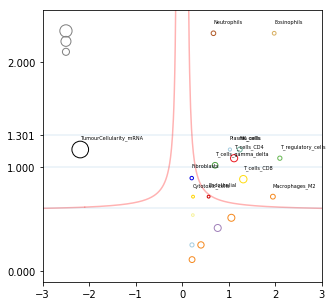

In [48]:
sig_sets = []
fig, ax = plt.subplots()
fig.set_size_inches(5,5)
for i in volcano_data.index:
    
    x = volcano_data.nes_dif[i]
    y = volcano_data.log10_q_comparison[i]
    c = volcano_data.colors[i]
    l = volcano_data.scores[i]
    s = volcano_data.msizes[i]
    plt.scatter(x, y, c='None', alpha=1, edgecolors=c, s=s, label=l)
    
    if y > -np.log10(0.25):
        
        plt.annotate(scores[i], xy=(x,y), xytext=(x, y+0.1), fontsize=5)
        sig_sets.append(scores[i])
        
    if y > -np.log10(0.25):
    
            print(scores[i])
    
plt.scatter(-2.5, 2.3, c='None', alpha=1, edgecolors='gray', s=150)
plt.scatter(-2.5, 2.2, c='None', alpha=1, edgecolors='gray', s=100)
plt.scatter(-2.5, 2.1, c='None', alpha=1, edgecolors='gray', s=50)
plt.plot([i[0] for i in curve_pos], [i[1] for i in curve_pos], 'r-', alpha=0.3)    
plt.plot([i[0] for i in curve_neg], [i[1] for i in curve_neg], 'r-', alpha=0.3)                
plt.axhline(y=-np.log10(0.25),alpha=0.1)
plt.axhline(y=-np.log10(0.1),alpha=0.1)
plt.axhline(y=-np.log10(0.05),alpha=0.1)
plt.xlim((-3,3))
plt.ylim((-0.1,2.5))
plt.yticks([-np.log10(1),-np.log10(0.1),-np.log10(0.05),-np.log10(0.01)])

plt.show()

In [49]:
fig.savefig('../../Figures/main/6/panels/6a_NACT_paired_matched_consensusTME_comparisons.pdf')

## Unmatched comparison

In [50]:
scores = []
p_comparisons = []
nes_dif = []
nes_treated_list = []
nes_untreated_list = []
nes_norm_treated_list = []
nes_norm_untreated_list = []
q_value_treated = []
q_value_untreated = []
colors = []
msizes = []
for score in data_nes.T:

    df_nes = pd.concat([sample_labels['Matched'],
                        sample_labels['NACT'],
                        data_nes.T[score]],
                        axis=1)

    df_nes = df_nes[df_nes['Matched'] == False]

    norm = test_paired_normality_and_variance(df_nes, score)

    scores.append(score)
    p_comparisons.append(test_paired_difference(df_nes, score, norm))
    nes_treated_list.append(df_nes[df_nes.NACT=='Treated'][score].median())
    nes_untreated_list.append(df_nes[df_nes.NACT=='Untreated'][score].median())
    nes_dif.append(nes_paired_difference(df_nes, score)[0])
    nes_norm_treated_list.append(nes_paired_difference(df_nes, score)[1])
    nes_norm_untreated_list.append(nes_paired_difference(df_nes, score)[2])
    colors.append(color_sets.get(score,'k'))
    
    if score in msize_dt:
        msizes.append(msize_dt[score])
    else:
        raise ValueError()

qs = multipletests(pvals=p_comparisons,
                   alpha=0.05,
                   method='fdr_bh',
                   is_sorted=False)

/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))


bartlett
bartlett
bartlett


/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))


bartlett
bartlett


/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))


bartlett
bartlett


/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))


bartlett
bartlett


/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))


bartlett
bartlett


/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))


bartlett
bartlett


/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))


bartlett
bartlett


/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))


bartlett
bartlett


/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))


bartlett
bartlett


In [51]:
ps_real = p_comparisons
qs_real = qs[1]
log10_ps_plot = abs(np.log10(p_comparisons))
log10_qs_plot = abs(np.log10(qs[1]))

### Volcano plot

In [52]:
volcano_data = pd.DataFrame({'scores': pd.Series(scores),
                             'qs':pd.Series(qs_real),
                             'ps':pd.Series(ps_real),
                             'log10_q_comparison': pd.Series(log10_qs_plot),
                             'log10_p_comparison': pd.Series(log10_ps_plot),
                             'nes_dif': pd.Series(nes_dif),
                             'nes_treated': pd.Series(nes_treated_list),
                             'nes_untreated': pd.Series(nes_untreated_list),
                             'nes_norm_treated': pd.Series(nes_norm_treated_list),
                             'nes_norm_untreated': pd.Series(nes_norm_untreated_list),
                             'colors': pd.Series(colors),
                             'msizes':pd.Series(msizes)})

In [53]:
volcano_data[volcano_data.scores == 'TumourCellularity_mRNA']

,scores,qs,ps,log10_q_comparison,log10_p_comparison,nes_dif,nes_treated,nes_untreated,nes_norm_treated,nes_norm_untreated,colors,msizes
18,TumourCellularity_mRNA,0.941341,0.485446,0.026253,0.313859,0.198384,0.713719,0.690764,0.540076,0.470691,k,278


### Hyperbolic curves

In [54]:
sample_size = len(df_nes)/2

In [55]:
t0 = 1.2
s0 = 0.1/t0

In [56]:
xs = range(-3 * 100, 3 *100)

## generate the x-axis for a hyperbolic curve defined as above
curve = [i/100 for i in xs if abs(i/100) > s0 * t0]

## generate the coordinates (x, y) for a hyperbolic curve defined as above
curve = [(i, hyperbolic(i, s0=s0, t0=t0)) for i in curve]

curve_pos = curve[:91]
curve_neg = curve[91:]

In [57]:
volcano_data.sort_values(by='msizes', inplace=True)

#### Volcano plot

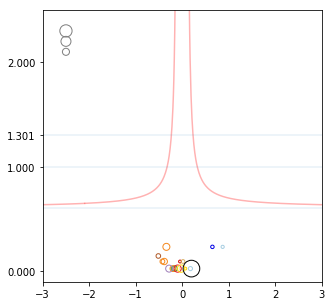

In [59]:
sig_sets = []
fig, ax = plt.subplots()
fig.set_size_inches(5,5)
for i in volcano_data.index:
    
    x = volcano_data.nes_dif[i]
    y = volcano_data.log10_q_comparison[i]
    c = volcano_data.colors[i]
    l = volcano_data.scores[i]
    s = volcano_data.msizes[i]
    plt.scatter(x, y, c='None', alpha=1, edgecolors=c, s=s, label=l)
    
    if y > -np.log10(0.25):
    
        plt.annotate(scores[i], xy=(x,y), xytext=(x, y+0.1), fontsize=5)
        sig_sets.append(scores[i])
    
plt.scatter(-2.5, 2.3, c='None', alpha=1, edgecolors='gray', s=150)
plt.scatter(-2.5, 2.2, c='None', alpha=1, edgecolors='gray', s=100)
plt.scatter(-2.5, 2.1, c='None', alpha=1, edgecolors='gray', s=50)
plt.plot([i[0] for i in curve_pos], [i[1] for i in curve_pos], 'r-', alpha=0.3)    
plt.plot([i[0] for i in curve_neg], [i[1] for i in curve_neg], 'r-', alpha=0.3)                
plt.axhline(y=-np.log10(0.25),alpha=0.1)
plt.axhline(y=-np.log10(0.1),alpha=0.1)
plt.axhline(y=-np.log10(0.05),alpha=0.1)
plt.xlim((-3,3))
plt.ylim((-0.1,2.5))
plt.yticks([-np.log10(1),-np.log10(0.1),-np.log10(0.05),-np.log10(0.01)])

plt.show()

In [60]:
fig.savefig('../../Figures/main/6/panels/6a_NACT_paired_unmatched_consensus_comparisons.pdf')

## Compare immune cells matched vs unmatched preNACT

This analysis allows us to see if the samples are comparable between each other, which in principle they should.

### pre NACT comparison

In [61]:
data_nes

,A01,A02,A03,A04,A05,A06,A07,A08,A09,A10,...,D12,E01,E02,E03,E04,E05,E06,E07,E08,E09
Term,,,,,,,,,,,,,,,,,,,,,
B_cells,0.254477,0.183183,0.328434,0.222920,0.158446,0.208608,0.153616,0.241499,0.227171,0.243108,...,0.282397,0.200239,0.268572,0.135625,0.237829,0.174235,0.346601,0.451349,0.345059,0.261922
Cytotoxic_cells,0.160124,0.086828,0.250783,0.469283,0.149997,0.280421,0.183015,0.136132,-0.013996,-0.005431,...,0.119812,0.128451,0.053743,-0.061381,0.264916,0.130406,0.056087,0.426493,0.242746,0.000835
Dendritic_cells,0.234120,0.242725,0.358290,0.249668,0.096655,0.219568,0.186520,0.244219,0.175394,0.125974,...,0.195455,0.213759,0.300447,0.175864,0.352042,0.078574,0.344772,0.479416,0.396381,0.237165
Endothelial,0.141871,-0.031062,0.359779,0.385954,-0.038934,0.295855,-0.023180,0.343295,0.143790,0.186743,...,0.214454,0.263538,0.230676,0.182908,0.467953,0.115959,0.192065,0.339805,0.233110,0.231086
Eosinophils,-0.104190,-0.001942,0.118276,0.292186,-0.136142,-0.127744,0.022336,0.303864,-0.069590,0.074915,...,-0.178187,-0.153298,0.104774,-0.223999,0.083588,-0.064987,0.086109,0.351228,0.080969,0.007399
Fibroblasts,0.092419,0.093467,0.304250,0.499391,0.034149,0.030490,0.275705,0.475787,0.197222,0.128937,...,0.154082,0.304058,0.256775,0.178976,0.543118,0.455606,0.150162,0.394732,0.205927,0.471352
Macrophages,0.267011,0.283663,0.409127,0.284822,0.230793,0.388582,0.320211,0.382658,0.312837,0.243805,...,0.324991,0.273914,0.325531,0.277977,0.381725,0.243272,0.397357,0.565551,0.455494,0.310526
Macrophages_M1,0.172090,0.104845,0.295066,0.218594,0.127381,0.281259,0.136686,0.256550,0.162905,0.169096,...,0.233327,0.175733,0.222949,0.216427,0.263176,0.120870,0.341486,0.551005,0.425049,0.200408
Macrophages_M2,0.181448,0.196052,0.321067,0.312852,0.204350,0.398029,0.279163,0.435695,0.175126,0.166479,...,0.323555,0.270164,0.276464,0.172137,0.386043,0.168484,0.428311,0.502084,0.392324,0.220806


In [62]:
sample_labels.head()

,Name,Case_mRNA,NACT,Site,Bounds,Matched
Well,,,,,,
A01,A01_3368A_Liver,3368,Untreated,other,in,True
A02,A02_3368B_Liver,3368,Treated,other,out,True
A03,A03_0371A_R_diaphragm,371,Untreated,other,out,True
A04,A04_0371B_R_diaphragm,371,Treated,other,out,True
A05,A05_9717A_R_ovary,9717,Untreated,ovary,in,True


In [63]:
scores = []
p_comparisons = []
nes_dif = []
nes_matched_list = []
nes_unmatched_list = []
nes_norm_matched_list = []
nes_norm_unmatched_list = []
q_value_matched = []
q_value_unmatched = []
colors = []
msizes = []
for score in data_nes.T:

    df_nes = pd.concat([sample_labels['Matched'],
                        sample_labels['NACT'],
                        data_nes.T[score]],
                        axis=1)

    df_nes = df_nes[df_nes['NACT'] == "Untreated"]

    norm = test_unpaired_normality_and_variance(df_nes, score)

    scores.append(score)
    p_comparisons.append(test_unpaired_difference(df_nes, score, norm))
    nes_matched_list.append(df_nes[df_nes.Matched==True][score].median())
    nes_unmatched_list.append(df_nes[df_nes.Matched==False][score].median())
    nes_dif.append(nes_unpaired_difference(df_nes, score)[0])
    nes_norm_matched_list.append(nes_unpaired_difference(df_nes, score)[1])
    nes_norm_unmatched_list.append(nes_unpaired_difference(df_nes, score)[2])
    colors.append(color_sets.get(score,'k'))
    
    if score in msize_dt:
        msizes.append(msize_dt[score])
    else:
        raise ValueError()

qs = multipletests(pvals=p_comparisons,
                   alpha=0.05,
                   method='fdr_bh',
                   is_sorted=False)

/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))


bartlett
welch
bartlett
welch


/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))


bartlett
welch
bartlett
welch


/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))


bartlett
welch
bartlett
welch


/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))


bartlett
welch
bartlett
welch


/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))


bartlett
welch
bartlett
welch


/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))


bartlett
welch
bartlett
welch


/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))


bartlett
welch
bartlett
welch


/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))


bartlett
welch
bartlett
welch
bartlett
welch


/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))


bartlett
welch
bartlett
welch


/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))


In [64]:
ps_real = p_comparisons
qs_real = qs[1]
log10_ps_plot = abs(np.log10(p_comparisons))
log10_qs_plot = abs(np.log10(qs[1]))

In [65]:
nes_dif

[-0.6246686133988354,
 0.22333819166432975,
 -0.511381459061975,
 -0.5894091324452164,
 -0.6821010230506027,
 0.14573366530188986,
 -0.2561622051274134,
 -0.15554888742724268,
 -1.063018668911923,
 -0.1687261093883086,
 -0.541981146040091,
 -0.5286297178988774,
 -0.5026081516599619,
 -0.6274122782453981,
 -0.5287700304466069,
 -0.5414104216679637,
 -0.23000664160343876,
 -1.7721578573825905,
 0.5704696386574035]

In [66]:
volcano_data = pd.DataFrame({'scores': pd.Series(scores),
                             'qs':pd.Series(qs_real),
                             'ps':pd.Series(ps_real),
                             'log10_q_comparison': pd.Series(log10_qs_plot),
                             'log10_p_comparison': pd.Series(log10_ps_plot),
                             'nes_dif': pd.Series(nes_dif),
                             'nes_matched': pd.Series(nes_matched_list),
                             'nes_unmatched': pd.Series(nes_unmatched_list),
                             'nes_norm_matched': pd.Series(nes_norm_matched_list),
                             'nes_norm_unmatched': pd.Series(nes_norm_unmatched_list),
                             'colors': pd.Series(colors),
                             'msizes':pd.Series(msizes)})

In [67]:
volcano_data[volcano_data.scores == 'TumourCellularity_mRNA']

,scores,qs,ps,log10_q_comparison,log10_p_comparison,nes_dif,nes_matched,nes_unmatched,nes_norm_matched,nes_norm_unmatched,colors,msizes
18,TumourCellularity_mRNA,0.491886,0.310665,0.308136,0.507708,0.57047,0.740642,0.690764,0.549442,0.369993,k,278


In [68]:
sample_size = len(df_nes)/2
sample_size

14.0

In [69]:
t0 = 1.2
s0 = 0.1/t0

In [70]:
xs = range(-3 * 100, 3 *100)

## generate the x-axis for a hyperbolic curve defined as above
curve = [i/100 for i in xs if abs(i/100) > s0 * t0]

## generate the coordinates (x, y) for a hyperbolic curve defined as above
curve = [(i, hyperbolic(i, s0=s0, t0=t0)) for i in curve]

curve_pos = curve[:91]
curve_neg = curve[91:]

In [71]:
volcano_data.sort_values(by='msizes', inplace=True)

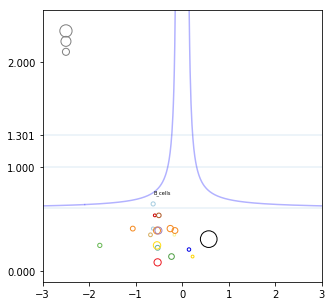

In [74]:
sig_sets = []
fig, ax = plt.subplots()
fig.set_size_inches(5,5)
for i in volcano_data.index:
    
    x = volcano_data.nes_dif[i]
    y = volcano_data.log10_q_comparison[i]
    c = volcano_data.colors[i]
    l = volcano_data.scores[i]
    s = volcano_data.msizes[i]
    plt.scatter(x, y, c='None', alpha=1, edgecolors=c, s=s, label=l)
    
    if y > -np.log10(0.25):
    
        plt.annotate(scores[i], xy=(x,y), xytext=(x, y+0.1), fontsize=5)
        sig_sets.append(scores[i])
    
plt.scatter(-2.5, 2.3, c='None', alpha=1, edgecolors='gray', s=150)
plt.scatter(-2.5, 2.2, c='None', alpha=1, edgecolors='gray', s=100)
plt.scatter(-2.5, 2.1, c='None', alpha=1, edgecolors='gray', s=50)
plt.plot([i[0] for i in curve_pos], [i[1] for i in curve_pos], 'b-', alpha=0.3)    
plt.plot([i[0] for i in curve_neg], [i[1] for i in curve_neg], 'b-', alpha=0.3)                
plt.axhline(y=-np.log10(0.25),alpha=0.1)
plt.axhline(y=-np.log10(0.1),alpha=0.1)
plt.axhline(y=-np.log10(0.05),alpha=0.1)
plt.xlim((-3,3))
plt.ylim((-0.1,2.5))
plt.yticks([-np.log10(1),-np.log10(0.1),-np.log10(0.05),-np.log10(0.01)])

plt.show()

In [75]:
fig.savefig('../../Figures/supplementary/6/panels/6sb_preNACT_unpaired_matchedVSunmatched_consensus_comparisons.pdf')

### post NACT comparison

In [76]:
scores = []
p_comparisons = []
nes_dif = []
nes_matched_list = []
nes_unmatched_list = []
nes_norm_matched_list = []
nes_norm_unmatched_list = []
q_value_matched = []
q_value_unmatched = []
colors = []
msizes = []
for score in data_nes.T:

    df_nes = pd.concat([sample_labels['Matched'],
                        sample_labels['NACT'],
                        data_nes.T[score]],
                        axis=1)

    df_nes = df_nes[df_nes['NACT'] == "Treated"]

    norm = test_unpaired_normality_and_variance(df_nes, score)

    scores.append(score)
    p_comparisons.append(test_unpaired_difference(df_nes, score, norm))
    nes_matched_list.append(df_nes[df_nes.Matched==True][score].median())
    nes_unmatched_list.append(df_nes[df_nes.Matched==False][score].median())
    nes_dif.append(nes_unpaired_difference(df_nes, score)[0])
    nes_norm_matched_list.append(nes_unpaired_difference(df_nes, score)[1])
    nes_norm_unmatched_list.append(nes_unpaired_difference(df_nes, score)[2])
    colors.append(color_sets.get(score,'k'))
    
    if score == "NK_cells":
        print(norm)
    
    if score in msize_dt:
        msizes.append(msize_dt[score])
    else:
        raise ValueError()

qs = multipletests(pvals=p_comparisons,
                   alpha=0.05,
                   method='fdr_bh',
                   is_sorted=False)

/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))


bartlett
welch
bartlett
welch


/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))


bartlett
welch
bartlett
welch


/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))


bartlett
welch
bartlett
welch


/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))


bartlett
welch
bartlett
welch
bartlett
welch


/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))


bartlett
welch
bartlett
welch


/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))


bartlett
welch
welch
bartlett
welch


/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))


bartlett
welch
bartlett
welch


/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))


bartlett
welch
bartlett
welch
bartlett
welch
bartlett
welch


/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))


In [77]:
ps_real = p_comparisons
qs_real = qs[1]
log10_ps_plot = abs(np.log10(p_comparisons))
log10_qs_plot = abs(np.log10(qs[1]))

In [78]:
min(qs_real)

0.12914236502761975

In [79]:
volcano_data = pd.DataFrame({'scores': pd.Series(scores),
                             'qs':pd.Series(qs_real),
                             'ps':pd.Series(ps_real),
                             'log10_q_comparison': pd.Series(log10_qs_plot),
                             'log10_p_comparison': pd.Series(log10_ps_plot),
                             'nes_dif': pd.Series(nes_dif),
                             'nes_matched': pd.Series(nes_matched_list),
                             'nes_unmatched': pd.Series(nes_unmatched_list),
                             'nes_norm_matched': pd.Series(nes_norm_matched_list),
                             'nes_norm_unmatched': pd.Series(nes_norm_unmatched_list),
                             'colors': pd.Series(colors),
                             'msizes':pd.Series(msizes)})

In [80]:
volcano_data[volcano_data.scores == 'TumourCellularity_mRNA']

,scores,qs,ps,log10_q_comparison,log10_p_comparison,nes_dif,nes_matched,nes_unmatched,nes_norm_matched,nes_norm_unmatched,colors,msizes
18,TumourCellularity_mRNA,0.357944,0.167974,0.446185,0.774758,-1.050082,0.621334,0.713719,0.317312,0.657042,k,278


In [81]:
sample_size = len(df_nes)/2
sample_size

14.0

In [82]:
t0 = 1.2
s0 = 0.1/t0

In [83]:
xs = range(-3 * 100, 3 *100)

## generate the x-axis for a hyperbolic curve defined as above
curve = [i/100 for i in xs if abs(i/100) > s0 * t0]

## generate the coordinates (x, y) for a hyperbolic curve defined as above
curve = [(i, hyperbolic(i, s0=s0, t0=t0)) for i in curve]

curve_pos = curve[:91]
curve_neg = curve[91:]

In [84]:
volcano_data.sort_values(by='msizes', inplace=True)

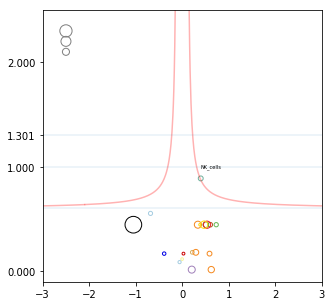

In [86]:
sig_sets = []
fig, ax = plt.subplots()
fig.set_size_inches(5,5)
for i in volcano_data.index:
    
    x = volcano_data.nes_dif[i]
    y = volcano_data.log10_q_comparison[i]
    c = volcano_data.colors[i]
    l = volcano_data.scores[i]
    s = volcano_data.msizes[i]
    plt.scatter(x, y, c='None', alpha=1, edgecolors=c, s=s, label=l)
    
    if y > -np.log10(0.25):
    
        plt.annotate(scores[i], xy=(x,y), xytext=(x, y+0.1), fontsize=5)
        sig_sets.append(scores[i])
    
plt.scatter(-2.5, 2.3, c='None', alpha=1, edgecolors='gray', s=150)
plt.scatter(-2.5, 2.2, c='None', alpha=1, edgecolors='gray', s=100)
plt.scatter(-2.5, 2.1, c='None', alpha=1, edgecolors='gray', s=50)
plt.plot([i[0] for i in curve_pos], [i[1] for i in curve_pos], 'r-', alpha=0.3)    
plt.plot([i[0] for i in curve_neg], [i[1] for i in curve_neg], 'r-', alpha=0.3)                
plt.axhline(y=-np.log10(0.25),alpha=0.1)
plt.axhline(y=-np.log10(0.1),alpha=0.1)
plt.axhline(y=-np.log10(0.05),alpha=0.1)
plt.xlim((-3,3))
plt.ylim((-0.1,2.5))
plt.yticks([-np.log10(1),-np.log10(0.1),-np.log10(0.05),-np.log10(0.01)])

plt.show()

In [87]:
fig.savefig('../../Figures/supplementary/6/panels/6sb_postNACT_unpaired_matchedVSunmatched_consensus_comparisons.pdf')

# End script